In [1]:
%pip install transformers
from transformers import ViltProcessor, ViltForQuestionAnswering, TrainingArguments, Trainer
import requests
from PIL import Image
import tensorflow as tf
import os
import json
from sklearn.utils import shuffle
import torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.1 MB/s 
     |████████████████████████████████| 596 kB 70.0 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [6]:
# prepare the training dataset
questions = {
      "man" : "is there a man ?",
      "woman": "is there a woman ?",
      "old" : "is there an old man ?",
      "girl" : "is there a girl ?",
      "boy" : "is there a boy ?",
      "babe" : "is there a babe ?",
      "dog" : "is there a dog ?",
      "sad" : "is anyone sad ?",
      "laughing" : "is anyone laughing ?",
      "angry" : "is anyone angry ?",
      "sitting" : "is anyone sitting ?",
      "walking" : "is anyone walking ?",
      "sleeping" : "is anyone sleeping ?",
      "eating" : "is anyone eating ?",
      "drinking" : "is anyone drinking ?",
      "hat" : "is anyone wearing a hat ?",
      "glasses": "is anyone wearing glasses ?",
      "one" : "is there a man ?",
      "two" : "are there two people ?",
      "three" : "are there three people ?",
      "four" : "are there four people ?",
      "five" : "are there five people ?",
      "joy" : "is anyone happy ?"
}

# the ViLT model is kept intact, due to limited data collected for fine-tuning
# the output of the model are chosen from more than 3000 vocabulary
# in our task, we only needs 'yes' and 'no'
Y = 3
N = 9
imgs_train = [] # a list of path to images
q_train = [] # a list of text questions
anno_train = [] # the corresponding answer
sub_folders = ["yes", "no"]
ans = {"yes":Y, "no":N}
data_dir = "simpsons_data/"
folders = [f for f in os.listdir(data_dir) if not f.startswith(".")]
for folder in folders:
  for sub_folder in sub_folders: # yes, no
    imgs_path = os.path.join(data_dir, folder, sub_folder)
    imgs = [f for f in os.listdir(imgs_path) if not f.startswith(".")]
    for img in imgs:
        imgs_train.append(os.path.join(imgs_path, img))
        q_train.append(questions[folder])
        anno_train.append(ans[sub_folder])


In [7]:
print(len(imgs_train))
print(anno_train[:5], q_train[:5])

6676
[3, 3, 3, 3, 3] ['is there a man ?', 'is there a man ?', 'is there a man ?', 'is there a man ?', 'is there a man ?']


In [22]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
# model = torch.load("model")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [9]:
# data augmentation
# code in this cell is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random
from torchvision.transforms.transforms import RandomHorizontalFlip
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.0:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.0))
    y0 = int(max(0, y0 - v / 2.0))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        # (AutoContrast, 0, 1),
        # (Equalize, 0, 1),
        (Rotate, 0, 45),
        # (Color, 0.1, 1.9),
        # (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1),
        (Sharpness, 0.1, 1),
        (ShearX, 0.0, 0.3),
        (ShearY, 0.0, 0.3),
        (CutoutAbs, 0, 20),
        (TranslateXabs, 0.0, 100),
        (TranslateYabs, 0.0, 100),
    ]

    return l



class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """

    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1:y2, x1:x2] = 0.0
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m  # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img

from torchvision import transforms


def pixelbert_transform_randaug():
    trs = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor()
        ]
    )
    trs.transforms.insert(0, RandAugment(2, 9))
    return trs

trs = pixelbert_transform_randaug()

In [11]:
import torch
from PIL import Image
from torch.utils.data import DataLoader

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, images, questions, annotations, processor, trs):
      self.images = images
      self.questions = questions
      self.annotations = annotations
      self.processor = processor 
      self.transforms = trs  

    def __len__(self):
      return len(self.annotations)

    def __getitem__(self, idx):
      img = Image.open(self.images[idx]).convert("RGB")
      img = img.resize((256, 256))
      img =  self.transforms(img)
      
      encoding = self.processor(img, self.questions[idx], padding="max_length", truncation=True, return_tensors="pt")
      item = {key: val.squeeze() for key, val in encoding.items()}
      targets = torch.zeros(3129) # convert the annotations to one-hot vectors
      targets[self.annotations[idx]] = 1
      item['labels'] = targets
      return item

train_dataset = VQADataset(imgs_train, q_train, anno_train, processor, trs)

In [12]:
print(train_dataset[0].keys())
print(processor.decode(train_dataset[0]['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])
[CLS] is there a man? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
training_args = TrainingArguments(
    output_dir = "./results",
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    learning_rate = 1e-5, # small learning rate for fine-tuning
    weight_decay=0.01,
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 959
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=150, training_loss=0.11246771494547526, metrics={'train_runtime': 306.5973, 'train_samples_per_second': 31.279, 'train_steps_per_second': 0.489, 'total_flos': 216612434858400.0, 'train_loss': 0.11246771494547526, 'epoch': 10.0})

In [ ]:
torch.save(model, "model")

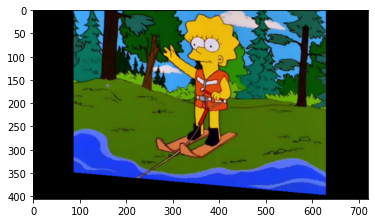

In [15]:
# show random data augmentation
import matplotlib.pyplot as plt

img = Image.open("simpsons/x3.jpeg").convert("RGB")
img = trs(img)
plt.imshow( img.permute(1, 2, 0))

(720, 406)
Predicted answer: yes


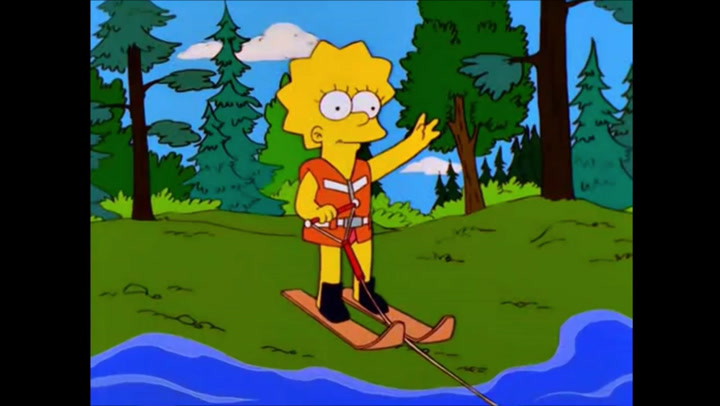

In [19]:
# run a test
answers = ["yes", "no"]
img = Image.open("simpsons/x3.jpeg").convert("RGB")
print(img.size)
encoding = processor(img, "is there any tree ?" , padding="max_length", truncation=True, return_tensors="pt")
encoding.to(device)
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])
img

In [ ]:
# compute accuracy on test dataset

from torch.utils.data import DataLoader
from transformers.tokenization_utils_base import BatchEncoding
import numpy as np

val_data = {2:[("are they the same age ?", Y), ("is there a table ?", N), ("are the boys happy ?", Y), ("are these boys twins ?", N)],
        3: [("is the lady happy ?", N), ("is the lady dancing ?", N), ("is the lady scared ? ", Y), ("is the man angry ?", Y)],
        8: [("is the man wearing green suit ?", Y), ("is he wearing glasses ?", Y), ("is the man wearing a bow tie ?", Y), ("is this outdoors ?", N), ("are they indoors ?", Y)],
        9: [("is it a rainy day ?", N), ("is he wearing glasses ?", N), ("is there a skateboard ?", Y), ("is the weather sunny ? ", Y)],
        11: [("is the boy wearing a hat?", Y), ("are they indoors ?", Y)],
        12: [("is the man angry ?", Y), ("is the man old ?", Y), ("is the windows open ?", N), ("is the man laughing ?", N)],
        13: [("is the man angry ?", N), ("is the man old ?", N)],
        14: [("are they standing ?", Y), ("is there two people ?", Y), ("is there three people ?", N)],
        16: [("is the man angry ?", N), ("is the man smiling ?", Y)],
        17: [("is the moon visible ? ", Y), ("is there a horse ?", Y), ("is there a dog ?", N)],
        18: [("is the man standing ? ", N), ("is the man in his bed ?", Y), ("is the man happy ? ", N)],
        20: [("is the boy wearing a hat?", N), ("is it a rainy day ?", N)],
        24: [("is the man wearing glasses ?", N), ("is the lady holding a dog ?", Y), ("are there dogs ?", Y), ("is the lady standing ?", N)],
        25: [("is the man smiling ?", N), ("is the man angry ?", Y), ("is there a ball ?", Y), ("is there a moon ?", N)],
        27: [("is the man in his bed ?", Y), ("are they indoors ?", Y), ("is the pillow black ?", N), ("is there a man and a girl ?", Y)],
        31: [("is he wearing glasses ?", N), ("is he happy ?", N), ("is he wearing a white shirt ?", Y), ("is there a people ?", Y)],
        35: [("is his eyes closed ?", Y), ("is there a girl ?", N), ("is his eyes open ?", N), ("is he wearing glasses ?", N)],
        37: [("are they in a car ?", Y)],
        38: [("is there any food on the table ?", Y)],
        39: [("is there two people ?", Y), ("is the lady waring a necklace ?", Y)],
        43: [("is there two people ?", Y), ("is there a girl ?", N), ("is there anyone standing ?", N), ("is there any one wearing glasses ?", Y)],
        44: [("is it daytime ?", N), ("is it night ?", Y), ("is it indoors ?", N), ("is there a moon ?", N), ("are there trees ?", Y)],
        49: [("is there four people ?", Y), ("is there three people ?", N)],
        56: [("is he eating ?", Y), ("is there two people ?", N)],
        59: [("is he happy ?", N), ("is there one people ?", Y),("are there two people ?", N)],
        60: [("are there two people ?", N), ("is the girl happy ?", N), ("is she walking ?", N), ("does the girl wear glasses ?", N), ("does the girl wear earphones ?", Y), ("is the girl sitting in the bed ?", Y), ("is the pillow white ?", N), ("is the pillow blue ?", Y)],
        61: [("are there two people ?", Y), ("are they in a car ?", Y), ("does they fasten the seatbelt ?", Y), ("is the lady driving ?", Y), ("does anyone wear earphones ?", N)],
        62: [("are there two people ?", Y), ("are they in a car ?", N), ("is the girl worried ?", N), ("does the girl wear a necklace ?", Y), ("is the boy wearing yellow shoes ?", N), ("is it daytime ?", N), ("is it night ?", Y)],
        63: [("is there a tree ?", Y), ("is there a girl ?", Y), ("is it daytime ?", Y), ("is she happy ?", N), ("is she smiling ?", N), ("is she laughing ?", N), ("is the girl worried ?", Y)],
        64: [("is there a people ?", Y)],
        65: [("is the girl in red walking ?", Y)],
        67: [("is any one happy ?", N), ("is the girl in red wearing a necklace ?", N), ("is the lady wearing a green swimming suit ?", N), ("is the lady in green wearing a necklace ?", Y), ("is the girl in the bed ?", Y), ("is the lady in the bed ?", N), ("is the girl standing ?", N), ("is the lady standing ?", Y)],
        68: [("is she happy ?", N), ("is anyone happy ?", N), ("is there two people ?", N), ("is there a baby ?", N)],
        69: [("is there a baby ?", Y), ("are there five people ?", Y), ("is the lady in wearing a green swimming suit ?", Y), ("is the lady in green wearing a necklace ?", N)]
        }
imgs_val = []
q_val = []
anno_val = []
for k, v in val_data.items():
  for qa in v:
    q, a = qa
    imgs_val.append("simpsons/" + str(k) + ".jpg")
    q_val.append(q)
    anno_val.append(a)

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, images, questions, processor):
        self.images = images
        self.questions = questions
        self.processor = processor   

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        img = img.resize((256, 256))
        encoding = self.processor(img, self.questions[idx], padding="max_length", truncation=True, return_tensors="pt")
        item = {key: val.squeeze() for key, val in encoding.items()}
        return item


val_dataset = VQADataset(imgs_val, q_val, processor)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Making predictions

y_predict = []
with torch.no_grad():
    for local_batch in val_dataloader:
        local_batch = BatchEncoding(local_batch)
        local_batch.to(device)
        outputs = model(**local_batch)
        pred = outputs.logits.argmax(1)
        y_predict += pred.tolist()

y_predict = np.array(y_predict)
y_copy = np.copy(y_predict)

sum(anno_val==y_predict) / len(y_predict)

0.6829268292682927

In [ ]:
# incorrectly answered
import matplotlib.pyplot as plt
incorrect_imgs = np.array(imgs_val)[anno_val!=y_predict]
incorrect_q = np.array(q_val)[anno_val!=y_predict]
incorrect_pred = y_predict[anno_val!=y_predict]
for i in range(len(incorrect_imgs)):
  img = Image.open(incorrect_imgs[i])
  plt.figure()
  plt.title(incorrect_q[i] +" "+ model.config.id2label[incorrect_pred[i]])
  plt.imshow(img)
  


In [ ]:
# before tuning 59.21, after tuning900 62.39, after tuning1000_2epoch 0.658

Another pretrained VQA model for comparison, it does not reach more than 50% accuary

In [ ]:
%pip install allennlp_models
from allennlp_models.pretrained import load_predictor
predictor = load_predictor("vqa-vilbert")

In [ ]:
image_path = "simpsons/18.jpg"
question = "is there a pillow ?"
preds = predictor.predict(image_path, question)
best_prob, best_answer = max(zip(preds["probs"], preds["tokens"]), key=lambda x: x[0])
print(f"p({best_answer}) = {best_prob:.2%}")

In [ ]:
predictions = []
for i in range(len(imgs_val)):
  preds = predictor.predict(image_path, q_val[i])
  best_prob, best_answer = max(zip(preds["probs"], preds["tokens"]), key=lambda x: x[0])
  predictions.append(best_answer)


In [ ]:
a = np.array(predictions)
b = np.ones(a.shape) * Y
#b[a=="yes"] = Y
b[a=="no"] = N

In [ ]:
sum(anno_val==b) / len(b)